In [1]:
from splitstep_CMDNLS import *

The Calogero-Moser Derivative Nonlinear Schrodinger equation is
$$iu_t + u_xx + 2 D_+ (|u|^2)u = 0.$$
After making the gauge transformation
$$v(x) := u(x)e^{-\frac{i}{2} \int_{-\infty}^x |u(y)|^2 dy},$$
we arrive at the equivalent equation
$$i v_t + v_{xx} + |D| (|v|^2) v - \frac{1}{4} |v|^4 v = 0.$$
Letting $A$ and $B$ be operators such that $Av = iv_{xx}$ and $Bv = i(|D|(|v|^2) - \frac{1}{4}|v|^4)v$, then we have
$$v_t = (A + B)v,$$
so that
$$v(t) = e^{t(A+B)}v_0.$$

To compute $e^{tA}$, we need to solve the linear Schrodinger equation
$$v_t = iv_{xx},$$
which yields
$$v(t+dt) = e^{i dt\partial_{xx}}v(t)$$
and can be solved on the fourier side via
$$\hat{v}(t + dt) = e^{-i dt \xi^2}\hat{v}(t)$$
This gives the ```linear_propagator``` function defined below.

To compute $e^{tB}$, we need to solve the nonlinear Schrodinger equation
$$v_t = i(|D|(|v|^2) - \frac{1}{4}|v|^4)v$$
Decomposing $v = \rho e^{i \theta}$, we find that
$$\rho_t e^{i\theta} + i \theta_t \rho e^{i\theta} = i(|D|(\rho^2) - \frac{1}{4}\rho^4)\rho e^{i\theta}$$
which implies that
$$\rho = \text{const}, \text{ and } \theta(t+dt) = i(|D|(\rho^2) - \frac{1}{4}\rho^4)dt + \theta(t)$$
Therefore
$$v(t + dt) = v*e^{i(|a sD|(\rho^2) - \frac{1}{4}\rho^4)dt}$$
which gives the ```nonlinear_propagator``` function defined below.

To combine these methods, we implement the split step method, which is based on
$$e^{t(A+B)} = e^{tA/2}e^{tB}e^{tA/2} + O(t^3).$$
This gives the ```split_step``` function defined below.

In [2]:
print_code()

```splitstep_CMDNLS.py``` is 
```python
#!/usr/bin/env python
"""
    splitstep_CMDNLS.py: Defines a numerical solver for CM-DNLS using a
    split-step method.
"""
__author__ = "James Hogan, Matthew Kowalski"
__email__  = "jameshogan@math.ucla.edu, mattkowalski@math.ucla.edu"

import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # used for visualizing progress of simulation
from matplotlib.animation import FuncAnimation # used to animate the result
from IPython.display import HTML # used to display the animation
from IPython.display import Markdown as md # used to print functions
import psutil # used to test if you have sufficient RAM
from sys import getsizeof

total_free_memory = psutil.virtual_memory().free

"""*****************************************************************************
Basic Function Definitions
*****************************************************************************"""
def gauge_transform(u, dx):
    # applies Tao's Gauge transformation to u
    v = u * np.exp(-0.5j * np.cumsum(np.abs(u)**2) * dx)
    return v

def inverse_gauge_transform(v, dx):
    # applies inverse of Tao's Gauge tranformation to v
    u = v * np.exp(0.5j * np.cumsum(np.abs(v)**2) * dx)
    return u

def pi_plus(v, xi):
    # applies the Szego projection (onto positive frequencies) to u
    v_hat = np.fft.fft(v)
    v_hat *= np.where(xi >= 0, 1, 0)
    v_new = np.fft.ifft(v_hat)
    return v_new

def abs_deriv(f, xi):
    # computes |D|f
    f_hat = np.fft.fft(f)
    f_hat *= np.abs(xi)
    f_new = np.fft.ifft(f_hat)
    return f_new

"""*****************************************************************************
Simulation Definition
*****************************************************************************"""
def linear_propagator(v, dt, xi):
    # returns exp(i dt |D|^2)v, applies the linear propagator to v for time dt
    v_hat = np.fft.fft(v)
    v_hat *= np.exp(-1j * dt * xi**2)
    v_new = np.fft.ifft(v_hat)
    return v_new

def nonlinear_propagator(v, dt, xi):
    # returns e^{dt B} v for Bv = i(|D|(|v|^2) - 0.25|v|^4)v
    v_new = v * np.exp(1j*dt * (abs_deriv(np.abs(v)**2,xi) - 0.25*np.abs(v)**4))
    return v_new

def split_step(v, dt, xi, order=2):
    # simulates timestep dt with split-step method of a specified order
    if order == 1 :
        v_new = linear_propagator(v,        dt, xi)
        v_new = nonlinear_propagator(v_new, dt, xi)
        return v_new
    elif order == 2 :
        v_new = linear_propagator(v,        dt/2, xi)
        v_new = nonlinear_propagator(v_new, dt,   xi)
        v_new = linear_propagator(v_new,    dt/2, xi)
        return v_new
    elif order == 4 :
        omega = (2 + np.power(2,1/3) + np.power(2,-1/3))/3
        v_new = linear_propagator(v,              omega*dt/2, xi)
        v_new = nonlinear_propagator(v_new,       omega*dt,   xi)
        v_new = linear_propagator(v_new,      (1-omega)*dt/2, xi)
        v_new = nonlinear_propagator(v_new, (1-2*omega)*dt,   xi)
        v_new = linear_propagator(v_new,      (1-omega)*dt/2, xi)
        v_new = nonlinear_propagator(v_new,       omega*dt,   xi)
        v_new = linear_propagator(v_new,          omega*dt/2, xi)
        return v_new
    elif order == 4.5 : # this is order 4, but slightly better
        omega = (4 + np.power(2,-2/3) + np.power(2,2/3))/15
        v_new = linear_propagator(v,              omega*dt/2, xi)
        v_new = nonlinear_propagator(v_new,       omega*dt,   xi)
        v_new = linear_propagator(v_new,          omega*dt,   xi)
        v_new = nonlinear_propagator(v_new,       omega*dt,   xi)
        v_new = linear_propagator(v_new,    (1-3*omega)*dt/2, xi)
        v_new = nonlinear_propagator(v_new, (1-4*omega)*dt,   xi)
        v_new = linear_propagator(v_new,    (1-3*omega)*dt/2, xi)
        v_new = nonlinear_propagator(v_new,       omega*dt,   xi)
        v_new = linear_propagator(v_new,          omega*dt,   xi)
        v_new = nonlinear_propagator(v_new,       omega*dt,   xi)
        v_new = linear_propagator(v_new,          omega*dt/2, xi)
        return v_new
    else :
        raise ValueError("Invalid order given. Accepted orders are 1,2,4,4.5.")

def evolve(u_0, dx, T=1.0, dt=0.01, animation_steps=1, order=2, ungauge=True,
           save = False, save_freq = 1000, save_location = 'evolve.npy'):
    v_0 = gauge_transform(u_0, dx)
    v_tmp = np.copy(v_0)
    N_x = len(v_0)
    xi = np.fft.fftfreq(N_x) * 2 * np.pi / dx
    N_t = int(T / dt)
    N_t_anim = math.ceil(N_t/animation_steps)
    # will_this_kill_my_computer(u_0, N_t_anim, memory_tolerance)
    v_anim = np.empty(shape=(N_t_anim, N_x), dtype=complex)
    t_anim = np.arange(0, T, dt)[::animation_steps]
    print("Evolving the gauge transformed data : ")
    for i in tqdm(range(N_t)):
        if i % animation_steps == 0:
            v_anim[int(i / animation_steps)] = v_tmp
        if save and (i % (save_freq*animation_steps) == 0):
            np.save(save_location, v_anim)
        v_tmp = split_step(v_tmp, dt, xi, order)
    if ungauge:
        print("Undoing the gauge transform : ")
        for i in tqdm(range(len(v_anim))):
            v_anim[i] = inverse_gauge_transform(v_anim[i], dx)
    return v_anim, t_anim, xi

def animate(f, t, x):
    fig, ax = plt.subplots()
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(0, np.max(np.abs(f)))
    line, = ax.plot(x, np.abs(f[0]))

    def update(frame):
        line.set_ydata(f[frame])
        return line,
    animation = FuncAnimation(fig, update, frames=len(t), interval=50, blit=True)
    # plt.show()
    return animation

"""*****************************************************************************
Conservation Laws
*****************************************************************************"""
def mass(u, dx):
    return np.sum(np.abs(u)**2) * dx

def H_s(u,s,dx,xi):
    u_hat = np.fft.fft(u)
    japanese = np.power(1 + np.abs(xi)**2,s/2)
    temp = np.fft.ifft(u_hat*japanese)
    return np.sqrt(dx*np.sum(np.abs(temp)**2))

def dot_H_s(u,s,dx,xi):
    u_hat = np.fft.fft(u)
    japanese = np.power(np.abs(xi),s)
    temp = np.fft.ifft(u_hat*japanese)
    return np.sqrt(dx*np.sum(np.abs(temp)**2))

def energy(u, dx, xi):
    integrand = np.gradient(u) / dx - 1j * pi_plus(np.abs(u)**2, xi) * u
    return 0.5 * np.sum(np.abs(integrand)**2) * dx

"""*****************************************************************************
Initial Data
*****************************************************************************"""
def one_soliton(t, x, lamb=1, phi=0, y=0):
    return np.exp(1j * phi) * np.sqrt(2 * lamb) / (lamb*x + y + 1j)

def two_soliton(t, x, gamma_1 = 0, gamma_2 = 0, rho = 1, lamb = 1, phi = 0):
    return (np.exp(1j * phi) * np.sqrt(2 * rho)
            * (gamma_2 + 2 * lamb * t + (1j / lamb) - x)
            / (x**2  - (gamma_1 - 1j*rho + gamma_2 + 2 * lamb * t) * x
               + (gamma_1 - 1j * rho) * (gamma_2 + 2 * lamb * t) - lamb**(-2)))

def bump(x, w=10) : # bump function supported on [-w,w]
    temp = np.empty(len(x))
    for i in range(len(x)):
        if np.abs(x[i]) < w:
            temp[i] = np.exp(1-w**2/(w**2-x[i]**2))
        else:
            temp[i] = 0
    return temp

"""*****************************************************************************
Printing this Code
*****************************************************************************"""
def print_code(func = "") :
    f = open("splitstep_CMDNLS.py", "r")
    s = f.read()
    if func :
        s = s[s.find("def "+func):]
        if len(s) == 1 :
            raise ValueError("Invalid function : "+func+" is not present in code")
        i = 1
        while s[i] != '\n' or s[i:i+2] in ['\n\n', '\n#', '\n '] :
            i += 1
        display(md("The "+func+" function is defined in ```splitstep_CMDNLS.py```"+
                   " as \n```python\n"+s[:i]
                   +"\n```"))
    else :
        display(md("```splitstep_CMDNLS.py``` is \n```python\n"+s+"\n```"))

"""*****************************************************************************
Diagnostics
*****************************************************************************"""
def will_this_kill_my_computer(u_0, N_t_anim, memory_tolerance=0.95):
    free_memory = psutil.virtual_memory().free
    size = getsizeof(u_0)
    usage = np.trunc(N_t_anim*size*(1e-7))/100
    total_usage = np.trunc(10000*N_t_anim*size/total_free_memory)/100
    current_usage = np.trunc(10000*N_t_anim*size/free_memory)/100
    print("Evolving this will use "+str(usage)+"GB which is "+str(total_usage)
          +"% of total available RAM and "+str(current_usage)
          +"% of currently available RAM.")
    if total_usage > 100*memory_tolerance:
        raise MemoryError("Generating this animation will use "
                          +str(total_usage)+"% of total available memory."
                          +" I suggest a smaller animation or a larger computer.")

```

## Example : 2-soliton

In [3]:
# initialize initial data
x_0 = -10000
x_1 = 10000
num = 2**18
dx = (x_1 - x_0)/(num - 1)
x = np.linspace(x_0, x_1, num)
u_0 = two_soliton(0,x)

In [5]:
# define timerfame and evolve data
T = 0.1
dt = 0.0001
u, t, xi = evolve(u_0, dx, T, dt, int(T/(100*dt)), 2) # returns xi for energy calculation later

Evolving the gauge transformed data : 


  0%|          | 0/1000 [00:00<?, ?it/s]

Undoing the gauge transform : 


  0%|          | 0/100 [00:00<?, ?it/s]

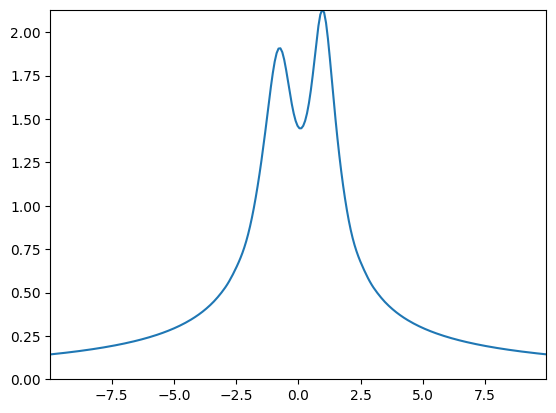

In [6]:
where = np.abs(x) < 10
anim = animate(np.abs(u[:,where]), t, x[where])
HTML(anim.to_jshtml())

# Checking Conservation Laws
## Mass :

  0%|          | 0/50 [00:00<?, ?it/s]

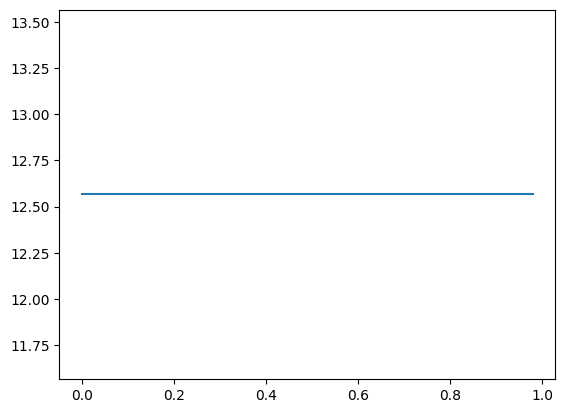

In [6]:
M = np.empty(shape = u.shape[0])
for i in tqdm(range(u.shape[0])):
    M[i] = mass(u[i],dx)
plt.ylim(M[0]-1,M[0]+1)
plt.plot(t,M)

## Energy :

  0%|          | 0/50 [00:00<?, ?it/s]

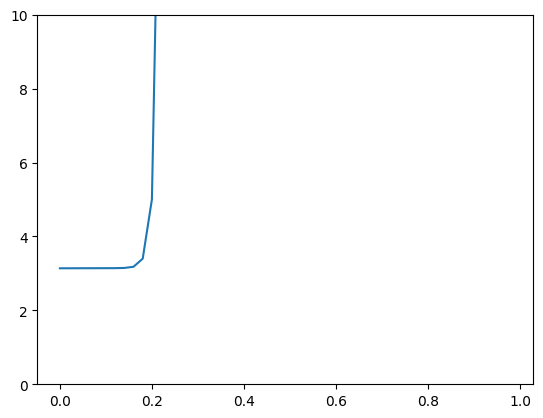

In [7]:
E = np.empty(shape=u.shape[0])
for i in tqdm(range(u.shape[0])):
    E[i] = energy(u[i], dx, xi)
plt.ylim(0,10)
plt.plot(t, E)

Evidently there is instability in the numerical methods. This instability seems to propagate from the boundary or from the peaks of the function.

## $H^s$ norm :

  0%|          | 0/50 [00:00<?, ?it/s]

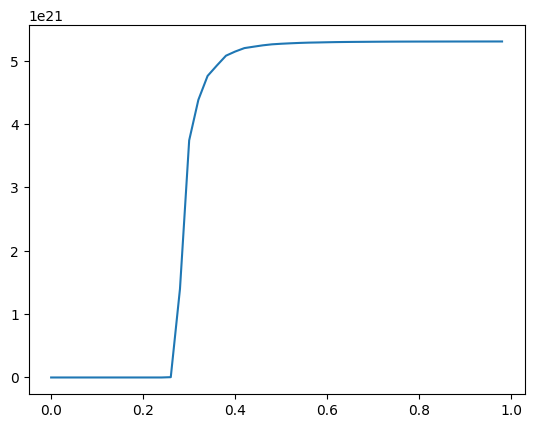

In [10]:
s = 3
H = np.empty(shape=u.shape[0])
for i in tqdm(range(u.shape[0])):
    H[i] = H_s(u[i], s, dx, xi)
plt.plot(t,H)

In [1]:
display("animations/bumped_soliton.gif")

'animations/bumped_soliton.gif'